In [14]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def combine_columns_to_embed(df):
    df['docs_to_embed'] = ''

    for idx, row in df.iterrows():
        new_str = '{}, {}, {}'.format(row['product_title'], row['review_headline'], row['review_body'])
        df.loc[idx, 'docs_to_embed'] = new_str
    
    return df



def read_data(f_name):
    data = []
    count = 0
    with open(f_name) as f:
        for row in f.readlines():
            data.append(row.strip('\n').split('\t'))
#             count += 1
#             print (count)
#             if count > 100:
#                 print ('tripped the if statement!')
#                 break
                
    df = pd.DataFrame(data[1:], columns = data[0])
    
    df.drop(['marketplace', 'review_id', 'product_parent'], axis=1, inplace=True)
    df = combine_columns_to_embed(df)
 
    return df

# need some help on figuring out why this takes forever to run
# df = read_data('amazon_reviews_us_Books_v1_00.tsv')


df = read_data('sample_us.tsv')

In [5]:
df.shape

(49, 13)

In [6]:
df.dtypes

customer_id          object
product_id           object
product_title        object
product_category     object
star_rating          object
helpful_votes        object
total_votes          object
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
docs_to_embed        object
dtype: object

In [5]:
cols_for_embeddings = ['product_title', 'review_headline', 'review_body']

In [6]:
cols_without_embeddings = ['customer_id', 'product_id', 'product_category', 'votes', 'vine', 'verified_purchase', 'date']

In [ ]:
# maybe consider date a running variable? 

In [7]:
def get_label(df):
    labels = [1 if int(x) >= 4 else 0 for x in df['star_rating'] ]
    return labels

labels = get_label(df)

## Build and train a model

### Features to embed:
1. Product title
2. Review headline
3. Review body
4. Customer ID
5. Product ID 

In [8]:
def get_encoded_ids(df, id_name):

    assert id_name in ['customer_id', 'product_id', 'docs_to_embed']
    
    vocab_size = get_vocab_size(df, col_name = id_name)

    docs = df[id_name].values.tolist()
    
    encoded_ids = [one_hot(d, vocab_size) for d in docs]

    return np.array(encoded_ids)

def get_vocab_size(df, col_name):
    vocab_size = len(set((' ').join(df[col_name]).split()))
    return vocab_size

def get_max_length(df, col_name):
    max_length = 0
    for idx, row in df.iterrows():
        doc = row[col_name]
        l = len(doc.split())
        if l > max_length:
            max_length = l
            
    return max_length

def get_padded_documents(df):
    encoded_docs = get_encoded_ids(df, 'docs_to_embed')
    max_length = get_max_length(df, 'docs_to_embed')
    
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

### Add additional inputs
On top of looking at the textual data, we have a few additional columns we need to consider. Each of these we'll consider a running variable
1. Product category
2. Votes

In the tiny sample dataset, all the records are on the same date and are in the same product category, so there's no reason to include either date or product category in the first model. We'll specify all of these as  inputs, then pass them in as a list to our model

In [9]:
df['total_votes'].value_counts()

0    29
1    14
2     3
4     2
6     1
Name: total_votes, dtype: int64

### Train the model!

In [10]:
def get_model_input_specs(df):
    vocab_size = get_vocab_size(df, 'docs_to_embed')
    max_length = get_max_length(df, col_name = 'docs_to_embed')

    n_users = len(set(df['customer_id'].values.tolist()))
    n_products = len(set(df['product_id'].values.tolist()))

    return vocab_size, max_length, n_users, n_products

In [23]:
def get_model():
    
    vocab_size, max_length, n_users, n_products = get_model_input_specs(df)

    votes_input = Input(shape=[1,], name="Votes-Input")    
    
    doc_input = Input(shape=[max_length,], name="Document-Input")
    doc_embedding = Embedding(vocab_size, 8, name="Document-Embedding", input_length=max_length)(doc_input)
    doc_vec = Flatten(name="Flatten-Documents")(doc_embedding)

    product_input = Input(shape=[1], name="Product-Input")
    product_embedding = Embedding(n_products+1, 5, name="Product-Embedding")(product_input)
    product_vec = Flatten(name="Flatten-Products")(product_embedding)

    user_input = Input(shape=[1], name="User-Input")
    user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)

    user_vec = Flatten(name="Flatten-Users")(user_embedding)

    prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])

    # your model is a list of embedded inputs, then the dot product, then the scaled running variables 
    model = Model([user_input, product_input, doc_input, votes_input], prod)

    model.compile('adam', 'mean_squared_error')
    
    return model

In [24]:
def get_scaled(df, col_name):
    x = [int(x) for x in df[col_name]]
    
    x = np.reshape(x, (-1, 1))

    scaler_x = MinMaxScaler()

    scaler_x.fit(x)
    
    xscale = scaler_x.transform(x)

    return xscale

def get_model_input_data(df):
    
    padded_docs = get_padded_documents(df)
    
    encoded_product_ids = get_encoded_ids(df, 'product_id')
    
    encoded_customer_idx = get_encoded_ids(df, 'customer_id')

    votes = get_scaled(df, 'total_votes')
    
    return [encoded_customer_idx, encoded_product_ids, padded_docs, votes]

In [27]:
model = get_model()

data_input = get_model_input_data(df)

history = model.fit(data_input, df.star_rating, epochs=500, verbose=1, validation_split=0.2)

model.save('regression_model.h5')

Train on 39 samples, validate on 10 samples
Epoch 1/500
39/39 [==============================] - 1s 16ms/step - loss: 18.7188 - val_loss: 21.7050
Epoch 2/500
39/39 [==============================] - 0s 97us/step - loss: 18.7166 - val_loss: 21.7048
Epoch 3/500
39/39 [==============================] - 0s 75us/step - loss: 18.7144 - val_loss: 21.7045
Epoch 4/500
39/39 [==============================] - 0s 85us/step - loss: 18.7122 - val_loss: 21.7042
Epoch 5/500
39/39 [==============================] - 0s 107us/step - loss: 18.7099 - val_loss: 21.7039
Epoch 6/500
39/39 [==============================] - 0s 77us/step - loss: 18.7078 - val_loss: 21.7035
Epoch 7/500
39/39 [==============================] - 0s 93us/step - loss: 18.7056 - val_loss: 21.7031
Epoch 8/500
39/39 [==============================] - 0s 76us/step - loss: 18.7034 - val_loss: 21.7026
Epoch 9/500
39/39 [==============================] - 0s 87us/step - loss: 18.7012 - val_loss: 21.7021
Epoch 10/500
39/39 [=================

39/39 [==============================] - 0s 103us/step - loss: 18.1073 - val_loss: 21.6534
Epoch 81/500
39/39 [==============================] - 0s 96us/step - loss: 18.0895 - val_loss: 21.6530
Epoch 82/500
39/39 [==============================] - 0s 105us/step - loss: 18.0708 - val_loss: 21.6525
Epoch 83/500
39/39 [==============================] - 0s 95us/step - loss: 18.0520 - val_loss: 21.6520
Epoch 84/500
39/39 [==============================] - 0s 91us/step - loss: 18.0331 - val_loss: 21.6514
Epoch 85/500
39/39 [==============================] - 0s 97us/step - loss: 18.0141 - val_loss: 21.6507
Epoch 86/500
39/39 [==============================] - 0s 95us/step - loss: 17.9951 - val_loss: 21.6500
Epoch 87/500
39/39 [==============================] - 0s 102us/step - loss: 17.9745 - val_loss: 21.6494
Epoch 88/500
39/39 [==============================] - 0s 96us/step - loss: 17.9553 - val_loss: 21.6491
Epoch 89/500
39/39 [==============================] - 0s 91us/step - loss: 17.9343 

Epoch 159/500
39/39 [==============================] - 0s 85us/step - loss: 15.8015 - val_loss: 21.6414
Epoch 160/500
39/39 [==============================] - 0s 95us/step - loss: 15.7613 - val_loss: 21.6415
Epoch 161/500
39/39 [==============================] - 0s 86us/step - loss: 15.7223 - val_loss: 21.6418
Epoch 162/500
39/39 [==============================] - 0s 125us/step - loss: 15.6836 - val_loss: 21.6421
Epoch 163/500
39/39 [==============================] - 0s 122us/step - loss: 15.6443 - val_loss: 21.6426
Epoch 164/500
39/39 [==============================] - 0s 97us/step - loss: 15.6057 - val_loss: 21.6429
Epoch 165/500
39/39 [==============================] - 0s 97us/step - loss: 15.5651 - val_loss: 21.6435
Epoch 166/500
39/39 [==============================] - 0s 97us/step - loss: 15.5254 - val_loss: 21.6446
Epoch 167/500
39/39 [==============================] - 0s 74us/step - loss: 15.4856 - val_loss: 21.6456
Epoch 168/500
39/39 [==============================] - 0s 93us

39/39 [==============================] - 0s 79us/step - loss: 12.3550 - val_loss: 21.6690
Epoch 238/500
39/39 [==============================] - 0s 90us/step - loss: 12.3070 - val_loss: 21.6706
Epoch 239/500
39/39 [==============================] - 0s 87us/step - loss: 12.2577 - val_loss: 21.6722
Epoch 240/500
39/39 [==============================] - 0s 112us/step - loss: 12.2096 - val_loss: 21.6740
Epoch 241/500
39/39 [==============================] - 0s 94us/step - loss: 12.1602 - val_loss: 21.6757
Epoch 242/500
39/39 [==============================] - 0s 86us/step - loss: 12.1105 - val_loss: 21.6774
Epoch 243/500
39/39 [==============================] - 0s 89us/step - loss: 12.0625 - val_loss: 21.6792
Epoch 244/500
39/39 [==============================] - 0s 86us/step - loss: 12.0139 - val_loss: 21.6815
Epoch 245/500
39/39 [==============================] - 0s 83us/step - loss: 11.9641 - val_loss: 21.6837
Epoch 246/500
39/39 [==============================] - 0s 80us/step - loss: 1

39/39 [==============================] - 0s 99us/step - loss: 8.5425 - val_loss: 21.7747
Epoch 317/500
39/39 [==============================] - 0s 107us/step - loss: 8.4959 - val_loss: 21.7753
Epoch 318/500
39/39 [==============================] - 0s 104us/step - loss: 8.4501 - val_loss: 21.7756
Epoch 319/500
39/39 [==============================] - 0s 94us/step - loss: 8.4037 - val_loss: 21.7756
Epoch 320/500
39/39 [==============================] - 0s 97us/step - loss: 8.3570 - val_loss: 21.7758
Epoch 321/500
39/39 [==============================] - 0s 96us/step - loss: 8.3114 - val_loss: 21.7765
Epoch 322/500
39/39 [==============================] - 0s 89us/step - loss: 8.2634 - val_loss: 21.7771
Epoch 323/500
39/39 [==============================] - 0s 90us/step - loss: 8.2184 - val_loss: 21.7776
Epoch 324/500
39/39 [==============================] - 0s 86us/step - loss: 8.1711 - val_loss: 21.7781
Epoch 325/500
39/39 [==============================] - 0s 96us/step - loss: 8.1263 - 

39/39 [==============================] - 0s 94us/step - loss: 5.2255 - val_loss: 21.8848
Epoch 396/500
39/39 [==============================] - 0s 98us/step - loss: 5.1910 - val_loss: 21.8876
Epoch 397/500
39/39 [==============================] - 0s 87us/step - loss: 5.1549 - val_loss: 21.8902
Epoch 398/500
39/39 [==============================] - 0s 96us/step - loss: 5.1212 - val_loss: 21.8930
Epoch 399/500
39/39 [==============================] - 0s 87us/step - loss: 5.0856 - val_loss: 21.8959
Epoch 400/500
39/39 [==============================] - 0s 96us/step - loss: 5.0513 - val_loss: 21.8990
Epoch 401/500
39/39 [==============================] - 0s 86us/step - loss: 5.0153 - val_loss: 21.9022
Epoch 402/500
39/39 [==============================] - 0s 86us/step - loss: 4.9812 - val_loss: 21.9058
Epoch 403/500
39/39 [==============================] - 0s 96us/step - loss: 4.9469 - val_loss: 21.9093
Epoch 404/500
39/39 [==============================] - 0s 91us/step - loss: 4.9119 - va

39/39 [==============================] - 0s 99us/step - loss: 2.8724 - val_loss: 22.0590
Epoch 475/500
39/39 [==============================] - 0s 100us/step - loss: 2.8485 - val_loss: 22.0602
Epoch 476/500
39/39 [==============================] - 0s 101us/step - loss: 2.8258 - val_loss: 22.0615
Epoch 477/500
39/39 [==============================] - 0s 85us/step - loss: 2.8036 - val_loss: 22.0632
Epoch 478/500
39/39 [==============================] - 0s 90us/step - loss: 2.7802 - val_loss: 22.0646
Epoch 479/500
39/39 [==============================] - 0s 97us/step - loss: 2.7589 - val_loss: 22.0656
Epoch 480/500
39/39 [==============================] - 0s 97us/step - loss: 2.7360 - val_loss: 22.0671
Epoch 481/500
39/39 [==============================] - 0s 104us/step - loss: 2.7135 - val_loss: 22.0693
Epoch 482/500
39/39 [==============================] - 0s 84us/step - loss: 2.6928 - val_loss: 22.0720
Epoch 483/500
39/39 [==============================] - 0s 83us/step - loss: 2.6700 -

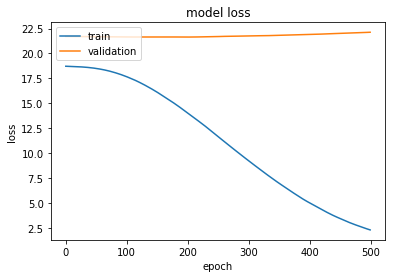

In [29]:
# print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()